In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_W5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Wed Mar 17 16:42:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
|103%   85C    P0   103W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 97%   

In [11]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = '/data/save/model_W5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json    save_138640  save_195000  save_240000  save_30000	 save_45000
save_100000  save_140000  save_196255  save_245000  save_300000  save_50000
save_100003  save_145000  save_20000   save_25000   save_305000  save_55000
save_105000  save_15000   save_200000  save_250000  save_310000  save_60000
save_108400  save_150000  save_205000  save_255000  save_312251  save_65000
save_110000  save_155000  save_207498  save_260000  save_315000  save_67743
save_112252  save_160000  save_20951   save_265000  save_320000  save_70000
save_112360  save_165000  save_210000  save_270000  save_320618  save_75000
save_113679  save_165513  save_213814  save_275000  save_325000  save_77732
save_115000  save_169764  save_215000  save_275660  save_330000  save_80000
save_120000  save_170000  save_220000  save_280000  save_330312  save_85000
save_125000  save_175000  save_224267  save_285000  save_35000	 save_85982
save_130000  save_180000  save_225000  save_290000  save_38005	 save_90000
save_131258  sa

In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 330312

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 132.9MiB
TTS size 45.2MiB
MelEncoder size 14.5MiB
MelDecoder size 28.7MiB
loaded : 330312
330312
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.03136203289031982


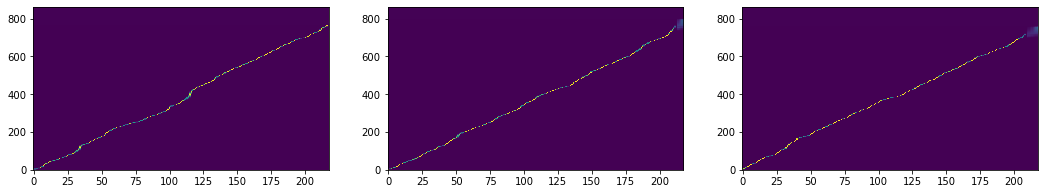

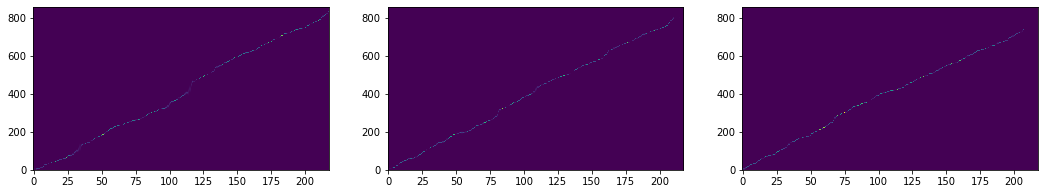

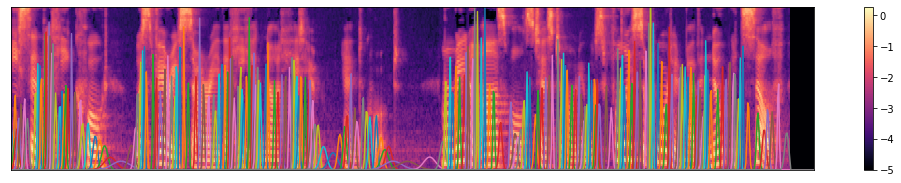

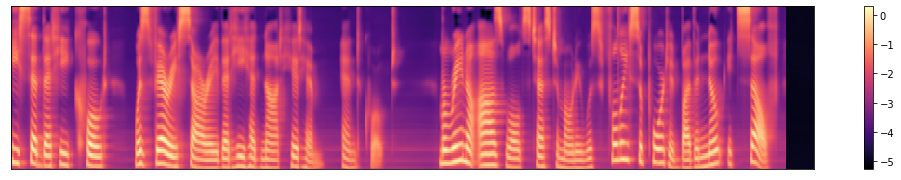

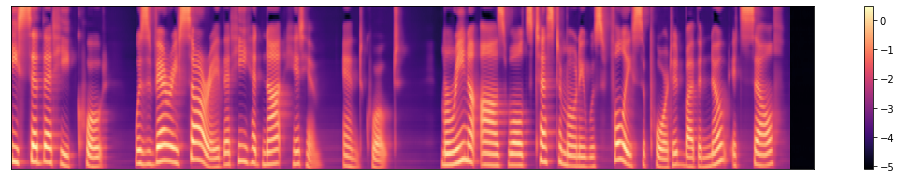

tensor(0.1441, device='cuda:0')
step : 348001 stt : 0.0008 tts : 0.1552 recon : 0.0287 kl : 0.0093 beta : 1.0000
tensor(0.1332, device='cuda:0')
step : 348002 stt : 0.0009 tts : 0.1411 recon : 0.0244 kl : 0.0082 beta : 1.0000
tensor(0.1350, device='cuda:0')
step : 348003 stt : 0.0004 tts : 0.1349 recon : 0.0242 kl : 0.0082 beta : 1.0000
tensor(0.1878, device='cuda:0')
step : 348004 stt : 0.0002 tts : 0.1480 recon : 0.0252 kl : 0.0083 beta : 1.0000
tensor(0.1486, device='cuda:0')
step : 348005 stt : 0.0015 tts : 0.1362 recon : 0.0259 kl : 0.0086 beta : 1.0000
tensor(0.1519, device='cuda:0')
step : 348006 stt : 0.0004 tts : 0.1411 recon : 0.0269 kl : 0.0088 beta : 1.0000
tensor(0.1412, device='cuda:0')
step : 348007 stt : 0.0006 tts : 0.1530 recon : 0.0284 kl : 0.0092 beta : 1.0000
tensor(0.1484, device='cuda:0')
step : 348008 stt : 0.0006 tts : 0.1330 recon : 0.0245 kl : 0.0082 beta : 1.0000
tensor(0.1432, device='cuda:0')
step : 348009 stt : 0.0010 tts : 0.1536 recon : 0.0302 kl : 0.00

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [9]:
logger.save(step, model, optimizer)

saved /data/save/model_W5G/save_330312


The Chronicles of Newgate, Volume two. By Arthur Griffiths. Section five: Newgate down to eighteen eighteen, part two.
torch.Size([1, 80, 708]) 0.028755378723144532
{'alignment': 0.0004665851593017578, 'random': 0.0020782947540283203, 'last_conv': 0.019297361373901367, 'z_proj': 0.0008029937744140625, 'cond': 0.00046515464782714844, 'up': 0.00035953521728515625, 'encode': 0.004326581954956055, 'pad': 3.719329833984375e-05, 'enc_conv': 0.0007252693176269531, 'enc_lstm': 0.003389120101928711}


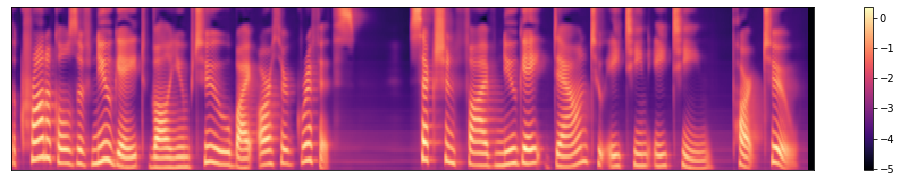

In [12]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 0:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [13]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(181248,)


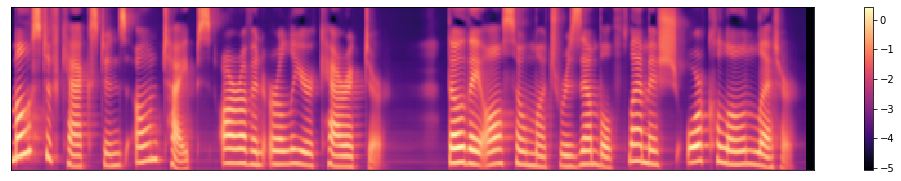

(159744,)


In [14]:
from g2p_en import G2p

g2p = G2p()
text = "Most of Caxton’s own types are of an earlier character, though they also much resemble Flemish or Cologne letter."
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():

    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)